## Energy_consumption
 

In [1]:
#!pip install pandas
#!pip install prophet
!pip install numpy pandas statsmodels scikit-learn keras tensorflow

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, GridSearchCV

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.5.2 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.14.5 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Loading the dataset (Daily_atmospheric_CO2_concentration)

In [2]:
data = pd.read_csv('Daily_atmospheric_CO2_concentration.csv',parse_dates=True)

In [3]:
data.head()

,Unnamed: 0,year,month,day,cycle,trend
0,0,2013,1,20,395.64,394.41
1,1,2013,1,21,395.67,394.42
2,2,2013,1,22,395.69,394.43
3,3,2013,1,23,395.72,394.43
4,4,2013,1,24,395.75,394.44


# Cleaning the dataset 

In [4]:
print("Mising values in dataset")
print(data.isnull().sum())

Mising values in dataset
Unnamed: 0    0
year          0
month         0
day           0
cycle         0
trend         0
dtype: int64


# Fill null values if any

In [5]:
data.fillna(method='ffill', inplace = True)

C:\Users\fatii\AppData\Local\Temp\ipykernel_21364\1921855967.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace = True)


In [6]:
print(data.isnull().sum())

Unnamed: 0    0
year          0
month         0
day           0
cycle         0
trend         0
dtype: int64


# Normalization/Standardization

In [7]:
scaler = StandardScaler()

In [8]:
data[['cycle','trend']]= scaler.fit_transform(data[['cycle','trend']])
print(data)

      Unnamed: 0  year  month  day     cycle     trend
0              0  2013      1   20 -1.498840 -1.712394
1              1  2013      1   21 -1.494736 -1.710988
2              2  2013      1   22 -1.491999 -1.709583
3              3  2013      1   23 -1.487895 -1.709583
4              4  2013      1   24 -1.483790 -1.708177
...          ...   ...    ...  ...       ...       ...
3653        3653  2023      1   21  1.767092  1.645434
3654        3654  2023      1   22  1.769829  1.646839
3655        3655  2023      1   23  1.773933  1.646839
3656        3656  2023      1   24  1.776670  1.648245
3657        3657  2023      1   25  1.780774  1.649650

[3658 rows x 6 columns]


# Stationarization

In [9]:
data['cycle_log'] = np.log(data['cycle']+1)
data['trend_log'] = np.log(data['trend']+1)


C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Differencing

In [10]:
data['cycle_diff'] = np.log(data['cycle'].diff().dropna())
data['trend_diff'] = np.log(data['trend'].diff().dropna())


C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
print(data[['cycle_diff', 'trend_diff']])

      cycle_diff  trend_diff
0            NaN         NaN
1      -5.495635   -6.567336
2      -5.901100   -6.567336
3      -5.495635        -inf
4      -5.495635   -6.567336
...          ...         ...
3653   -5.901100        -inf
3654   -5.901100   -6.567336
3655   -5.495635        -inf
3656   -5.901100   -6.567336
3657   -5.495635   -6.567336

[3658 rows x 2 columns]


# ARIMA:

## Visualize the time series data


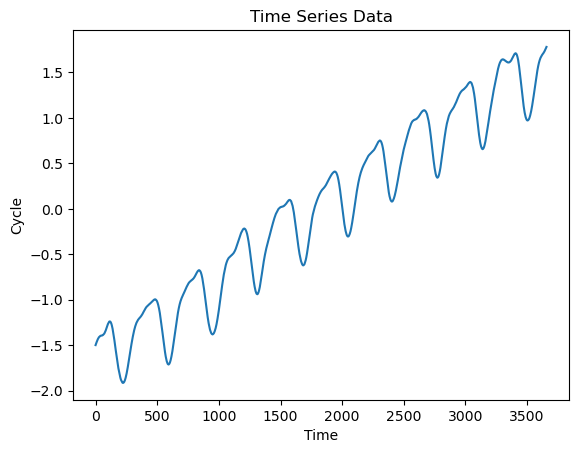

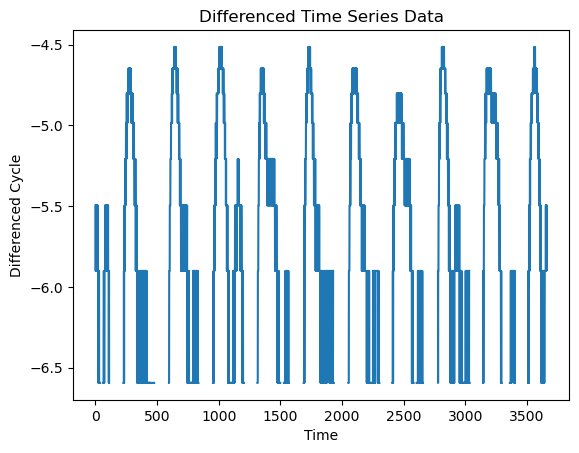

In [12]:
plt.plot(data['cycle'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Cycle')
plt.show()
# Visualize the differenced time series data
plt.plot(data['cycle_diff'])
plt.title('Differenced Time Series Data')
plt.xlabel('Time')
plt.ylabel('Differenced Cycle')
plt.show()

# Stationarity check


In [13]:
result = adfuller(data['cycle'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# If p-value < 0.05, data is stationary, otherwise, perform differencing


ADF Statistic: -1.4351614591698447
p-value: 0.5653080782145281


# Perform differencing


In [14]:
data['diff_cycle'] = data['cycle'].diff()

# Drop the first row with NaN resulting from differencing
data.dropna(inplace=True)

result = adfuller(data['diff_cycle'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.927938543853876
p-value: 3.5767717613418447e-12


# Plot ACF and PACF


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


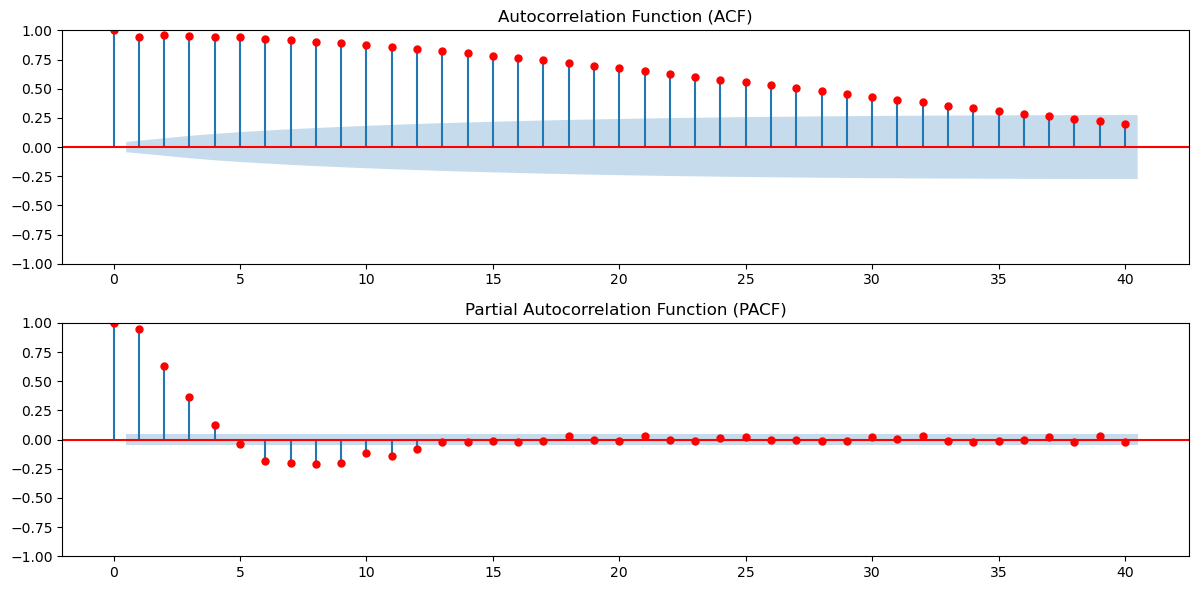

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['diff_cycle'],color='red', ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(data['diff_cycle'],color='red', ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


# Model Selection 


In [16]:
# Based on ACF and PACF plots and statistical tests
p = 5  # Number of significant spikes in PACF plot
d = 0  # No differencing needed as the data is already stationary
q = 36  # Number of significant spikes in ACF plot

# Step 6: Model Training
model = ARIMA(data['cycle'], order=(p, d, q))
model_fit = model.fit()

# Step 7: Model Evaluation
print(model_fit.summary())


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

                               SARIMAX Results                                
Dep. Variable:                  cycle   No. Observations:                 1932
Model:                ARIMA(5, 0, 36)   Log Likelihood                3309.651
Date:                Tue, 14 May 2024   AIC                          -6533.302
Time:                        18:33:04   BIC                          -6293.950
Sample:                             0   HQIC                         -6445.263
                               - 1932                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4919      0.842      0.584      0.559      -1.158       2.142
ar.L1         -0.6348     55.027     -0.012      0.991    -108.485     107.216
ar.L2         -0.0509     45.921     -0.001      0.9

# Forecasting


In [17]:
forecast_steps = 10  # Forecast 10 future time periods
forecast_values = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame to store forecasted values
forecast_df = pd.DataFrame({'Forecasted Values': forecast_values})

# Display forecasted values in tabular format
print("Forecasted Values:")
forecast_df


Forecasted Values:


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Forecasted Values
1932,1.779432
1933,1.778031
1934,1.776563
1935,1.775058
1936,1.773491
1937,1.771892
1938,1.770245
1939,1.768556
1940,1.766829
1941,1.765064


# ANN Design and Training 

##  Preparing Dataset

In [18]:
data = data.dropna(subset=['cycle_log'])

In [19]:
x= data['cycle_log'].values.reshape(-1,1)
y = data['cycle_log'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


## Designing ANN

In [21]:
# Function to create a model
def create_model(n_layers, n_neurons):
    model = Sequential()
    model.add(Dense(units=n_neurons, activation='relu', input_dim=1))  # Input layer
    for _ in range(n_layers - 1):
        model.add(Dense(units=n_neurons, activation='relu'))  # Adding hidden layers
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Training the model

In [22]:
layer_options = [1, 2, 3]  # Different number of layers
neuron_options = [20, 50, 100]  # Different number of neurons

results = {}
for layers in layer_options:
    for neurons in neuron_options:
        model = create_model(layers, neurons)
        model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=0)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        results[(layers, neurons)] = mse
        print(f'Layers: {layers}, Neurons: {neurons}, MSE: {mse}')


13/13 [==============================] - 0s 5ms/step
Layers: 1, Neurons: 20, MSE: 4.9021826360524306e-08
13/13 [==============================] - 0s 6ms/step
Layers: 1, Neurons: 50, MSE: 6.247301938574671e-07
13/13 [==============================] - 0s 2ms/step
Layers: 1, Neurons: 100, MSE: 5.21937679744051e-07
13/13 [==============================] - 0s 2ms/step
Layers: 2, Neurons: 20, MSE: 2.0586552822855387e-07
13/13 [==============================] - 0s 2ms/step
Layers: 2, Neurons: 50, MSE: 1.3980788867159826e-05
13/13 [==============================] - 0s 2ms/step
Layers: 2, Neurons: 100, MSE: 4.557557287567108e-06
13/13 [==============================] - 0s 2ms/step
Layers: 3, Neurons: 20, MSE: 1.6798018753789949e-06
13/13 [==============================] - 0s 2ms/step
Layers: 3, Neurons: 50, MSE: 6.068645741104968e-08
13/13 [==============================] - 0s 2ms/step
Layers: 3, Neurons: 100, MSE: 7.646997422435668e-08


## Evaluating the model

In [23]:
best_architecture = min(results, key=results.get)
best_mse = results[best_architecture]
print(f'Best Architecture -> Layers: {best_architecture[0]}, Neurons: {best_architecture[1]}, MSE: {best_mse}')

Best Architecture -> Layers: 1, Neurons: 20, MSE: 4.9021826360524306e-08


## Visualize the data

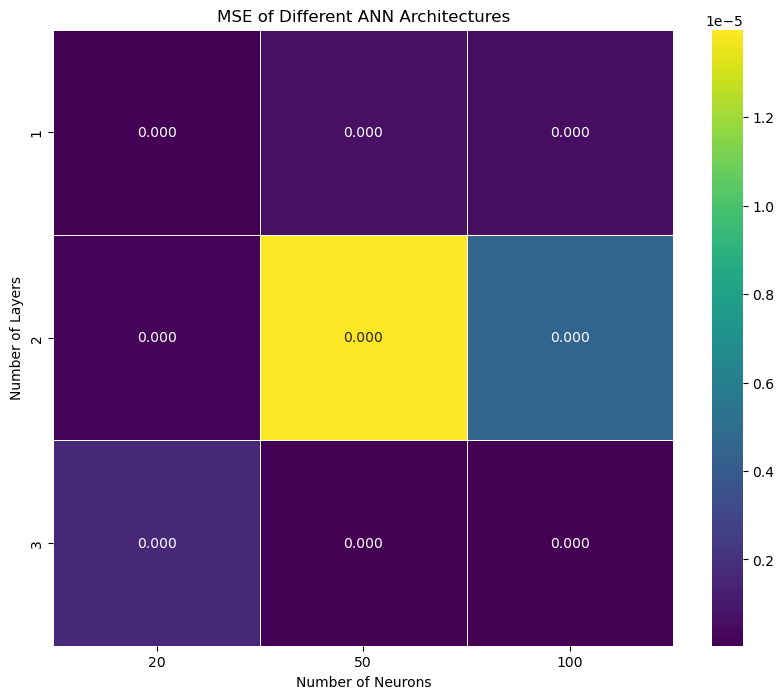

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'results' is a dictionary with keys as (layers, neurons) and values as MSE
data = {'Layers': [], 'Neurons': [], 'MSE': []}
for (layers, neurons), mse in results.items():
    data['Layers'].append(layers)
    data['Neurons'].append(neurons)
    data['MSE'].append(mse)

# Create a DataFrame
df = pd.DataFrame(data)

# Corrected pivot call: specify index, columns, and values explicitly
pivot_table = df.pivot(index='Layers', columns='Neurons', values='MSE')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
ax = plt.subplot()

# Draw the heatmap
sns.heatmap(pivot_table, annot=True, fmt=".3f", linewidths=.5, ax=ax, cmap="viridis")

# Title and labels
ax.set_title('MSE of Different ANN Architectures')
ax.set_xlabel('Number of Neurons')
ax.set_ylabel('Number of Layers')

# Show the plot
plt.show()


# SARIMA (Seasonal ARIMA):

In [25]:
data = pd.read_csv('Daily_atmospheric_CO2_concentration.csv', parse_dates=True)

ts = data['cycle']

## Checking if data is stationary

In [26]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.3f}')

adf_test(ts)


ADF Statistic: -1.435161459170062
p-value: 0.5653080782144225
Critical Values:
    1%: -3.432
    5%: -2.862
    10%: -2.567


## Seasonal Decomposition

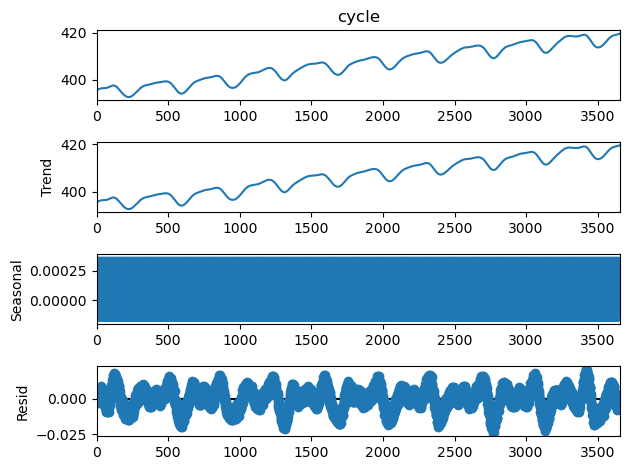

In [27]:
result = seasonal_decompose(ts, model='additive', period=12)  # change period based on your data's seasonality
result.plot()
plt.show()


# Identifying SARIMA Parameters

C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


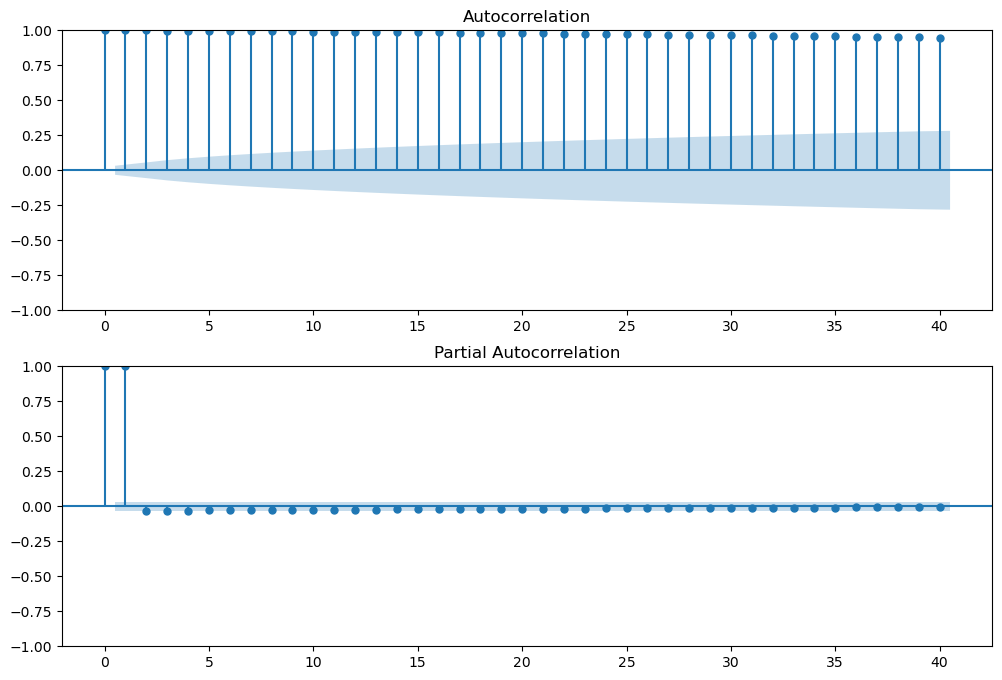

In [28]:
# Non-seasonal
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts, ax=ax[0], lags=40)  
plot_pacf(ts, ax=ax[1], lags=40)  
plt.show()



## Fitting SARIMA MODEL

In [29]:
model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)
print(results.summary())


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              cycle   No. Observations:                 3658
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               13655.047
Date:                            Tue, 14 May 2024   AIC                         -27300.094
Time:                                    18:53:38   BIC                         -27269.089
Sample:                                         0   HQIC                        -27289.052
                                           - 3658                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.002    527.172      0.000       0.996       1.003
ma.L1         -0.6001      0.017   

## Model Diagnostics and Validation

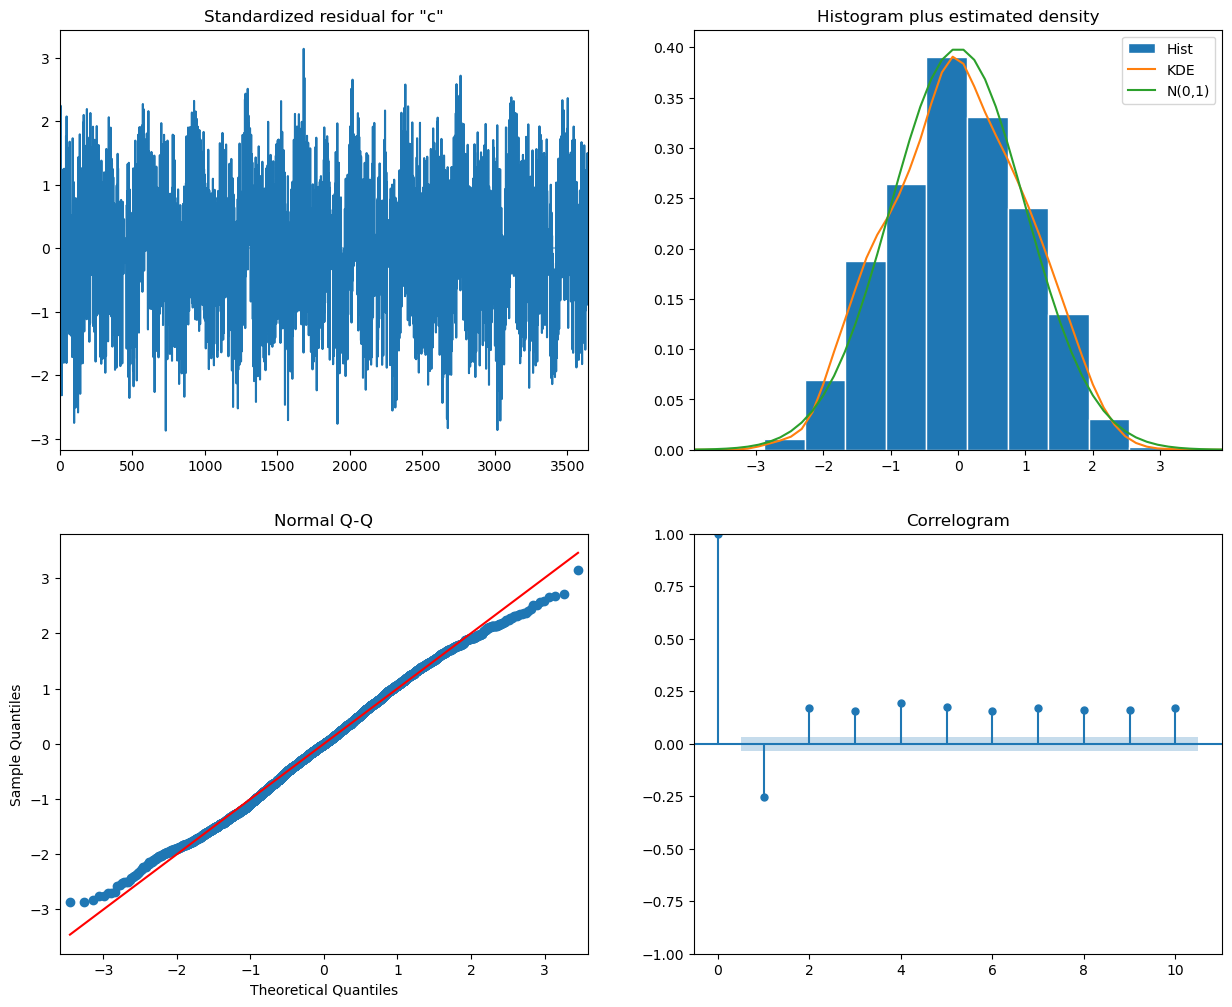

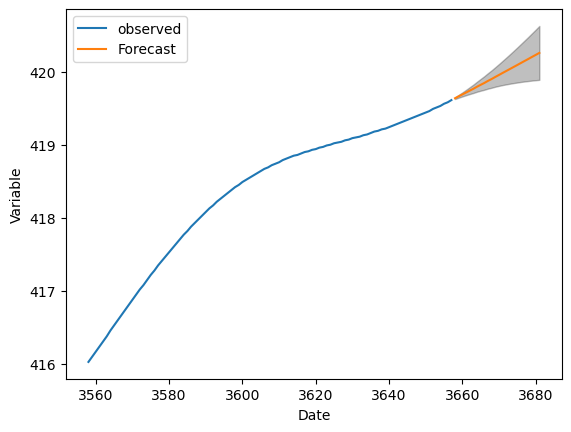

In [30]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting
pred = results.get_forecast(steps=24)  # Forecasting the next 24 time periods
pred_ci = pred.conf_int()
ax = ts[-100:].plot(label='observed')  # Last 100 observations
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Variable')
plt.legend()
plt.show()


# Exponential Smoothing (ETS):

## Configure and Fit ETS Models

In [31]:
# Simple Exponential Smoothing - for data with no clear trend or seasonality
model_simple = ExponentialSmoothing(ts, trend=None, seasonal=None, seasonal_periods=None)
fitted_model_simple = model_simple.fit()

# Double Exponential Smoothing - for data with a trend but no seasonality
model_double = ExponentialSmoothing(ts, trend='add', seasonal=None, seasonal_periods=None)
fitted_model_double = model_double.fit()

# Triple Exponential Smoothing - for data with both trend and seasonality
model_triple = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12) 
fitted_model_triple = model_triple.fit()


Simple Model AIC: -22993.736549713172 BIC: -22981.32720605527
Double Model AIC: -38373.4834128334 BIC: -38348.66472551759
Triple Model AIC: -38355.93532670035 BIC: -38256.66057743714


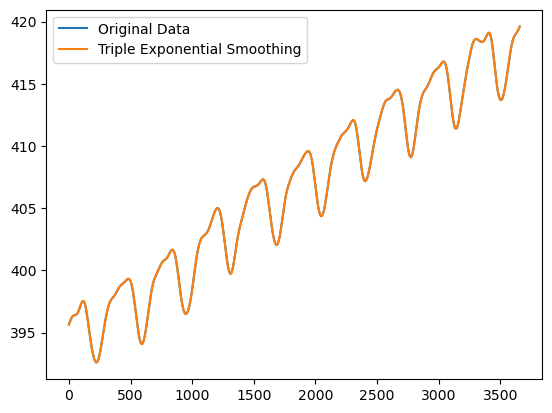

In [32]:
# Print AIC and BIC values to compare models
print('Simple Model AIC:', fitted_model_simple.aic, 'BIC:', fitted_model_simple.bic)
print('Double Model AIC:', fitted_model_double.aic, 'BIC:', fitted_model_double.bic)
print('Triple Model AIC:', fitted_model_triple.aic, 'BIC:', fitted_model_triple.bic)

# Plot the original data and the fitted values
ts.plot(label='Original Data', legend=True)
fitted_model_triple.fittedvalues.plot(label='Triple Exponential Smoothing', legend=True)
plt.show()


## Diagnostics and Validation


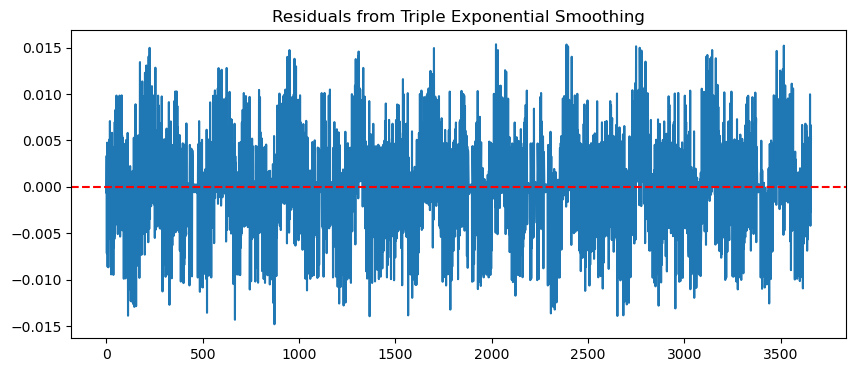

Statistics=10.390, p=0.006
Sample does not look Gaussian (reject H0)


In [33]:
# Assuming the triple model is the best
residuals = fitted_model_triple.resid

# Plotting residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from Triple Exponential Smoothing')
plt.axhline(y=0, color='r', linestyle='--')  # Zero line for reference
plt.show()

# Check for normality of residuals
from scipy.stats import normaltest
stat, p = normaltest(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


# Checking for autocorrelation

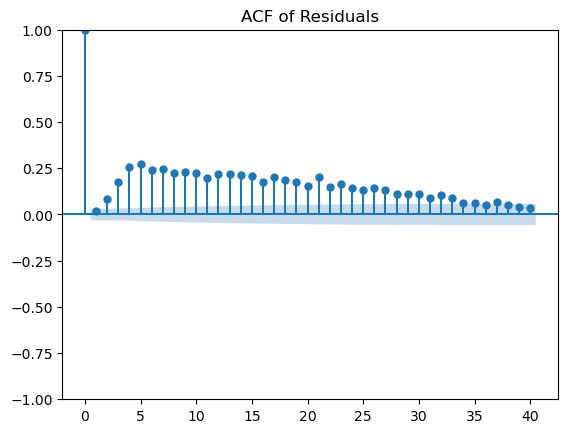

In [34]:

plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()


## Forecasting with Confidence Intervals


C:\Users\fatii\AppData\Local\Temp\ipykernel_21364\3180617622.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(ts.index[-1], periods=25, freq='M')[1:], forecast, label='Forecast')


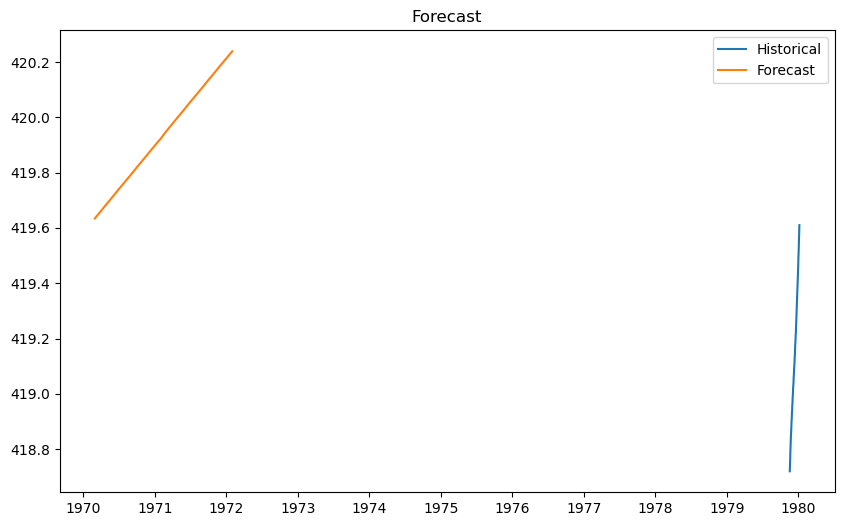

In [35]:
# Forecast the next 24 periods
forecast = fitted_model_triple.forecast(steps=24)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(ts.index[-50:], ts[-50:], label='Historical')
plt.plot(pd.date_range(ts.index[-1], periods=25, freq='M')[1:], forecast, label='Forecast')
plt.title('Forecast')
plt.legend()
plt.show()


# Prophet:

## Combining day, month, year

In [36]:
data['ds'] = pd.to_datetime(data[['year', 'month', 'day']])


In [37]:
data['y'] = data['cycle']


In [38]:
prophet_data = data[['ds', 'y']]
print(prophet_data.head())


          ds       y
0 2013-01-20  395.64
1 2013-01-21  395.67
2 2013-01-22  395.69
3 2013-01-23  395.72
4 2013-01-24  395.75


# Fitting a prophet model

18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


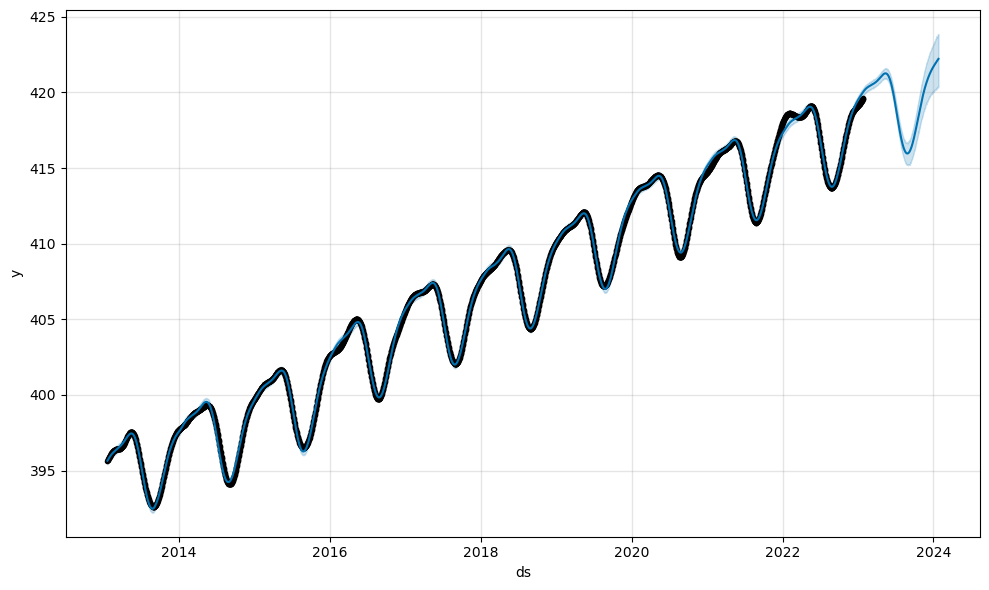

C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

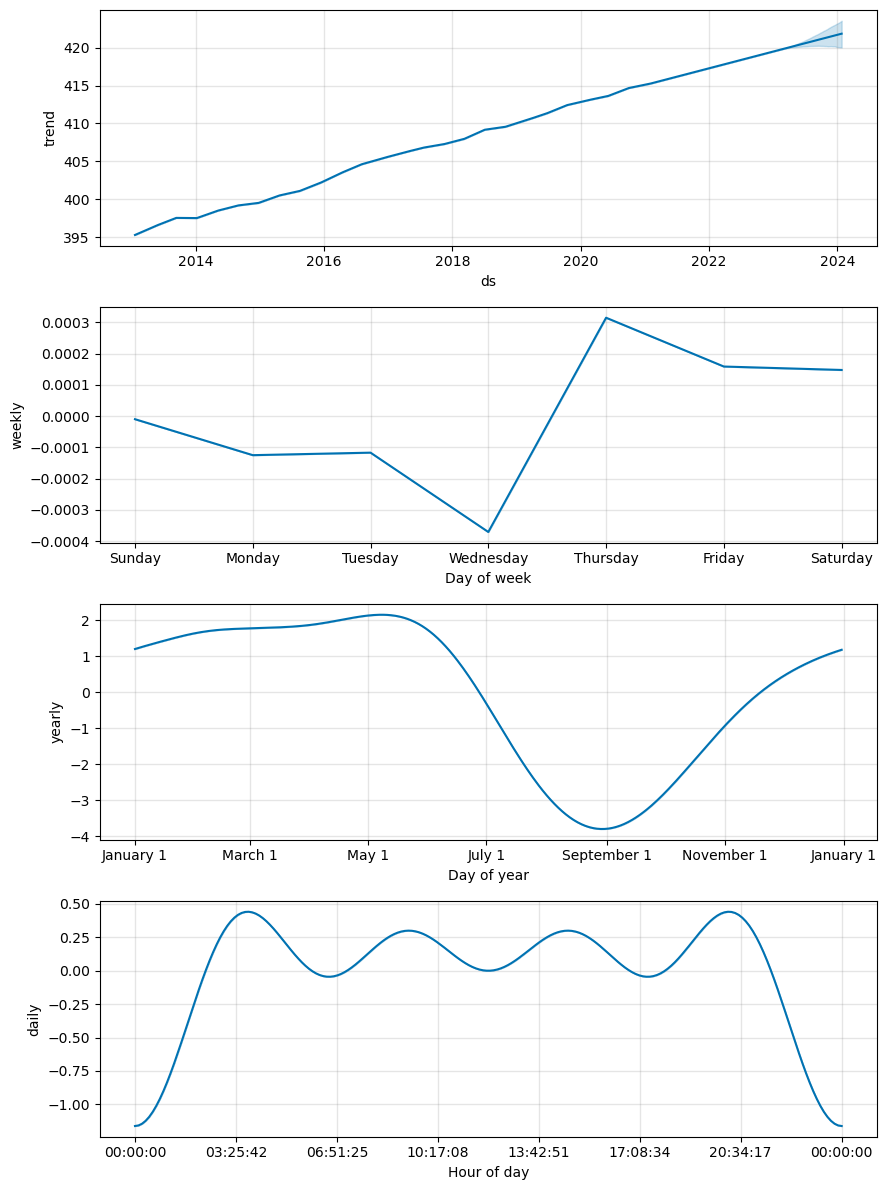

In [39]:
# Create a Prophet model instance
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Fit the model
m.fit(prophet_data)

# Create a DataFrame to hold predictions for the next 365 days
future = m.make_future_dataframe(periods=365)

# Make predictions
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
plt.show()

# Optionally, visualize the components of the forecast
components_fig = m.plot_components(forecast)
plt.show()


# Support Vector Regression (SVR):

In [40]:
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']])
X = data[['year', 'month', 'day']] 
y = data['cycle']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Configuring and Training SVR

In [42]:
# Initialize and fit the SVR model
svr_rbf = SVR(kernel='rbf', C=1.0, gamma='auto')  
svr_rbf.fit(X_train_scaled, y_train)


SVR(gamma='auto')

## Evaluating the model

In [43]:
# Predicting and evaluating the performance
y_pred = svr_rbf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.34961457565600107


## Parameter Tunining with Cross Validation

In [44]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
}

# Create GridSearchCV object
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and MSE
print("Best parameters:", grid_search.best_params_)
best_mse = -grid_search.best_score_
print(f'Best MSE from CV: {best_mse}')


Best parameters: {'C': 100, 'gamma': 1}
Best MSE from CV: 0.018810756925647817


## Visualizing the Results

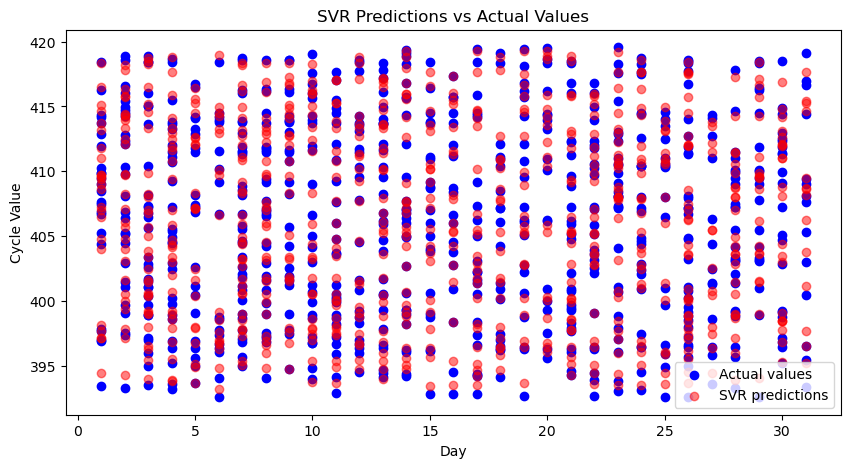

In [45]:
# Visualize predictions against actual data
plt.figure(figsize=(10, 5))
plt.scatter(X_test['day'], y_test, color='blue', label='Actual values')
plt.scatter(X_test['day'], y_pred, color='red', label='SVR predictions', alpha=0.5)
plt.xlabel('Day')
plt.ylabel('Cycle Value')
plt.title('SVR Predictions vs Actual Values')
plt.legend()
plt.show()


# Long Short-Term Memory (LSTM):

## Scaling the data

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['cycle']].values.reshape(-1, 1))

# Function to create a dataset as required by LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  #number of previous timestamps
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

## Desigining LTSM Network

In [47]:
# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))  # 50 neurons in the LSTM layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


## Training the model

In [48]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
2924/2924 - 12s - loss: 0.0085 - 12s/epoch - 4ms/step
Epoch 2/5
2924/2924 - 9s - loss: 2.1595e-05 - 9s/epoch - 3ms/step
Epoch 3/5
2924/2924 - 15s - loss: 8.7412e-06 - 15s/epoch - 5ms/step
Epoch 4/5
2924/2924 - 13s - loss: 1.0273e-05 - 13s/epoch - 4ms/step
Epoch 5/5
2924/2924 - 11s - loss: 1.1939e-05 - 11s/epoch - 4ms/step


## Making predictions and Evaluating the model

In [49]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))


23/23 [==============================] - 0s 4ms/step
Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


## Plotting the Results

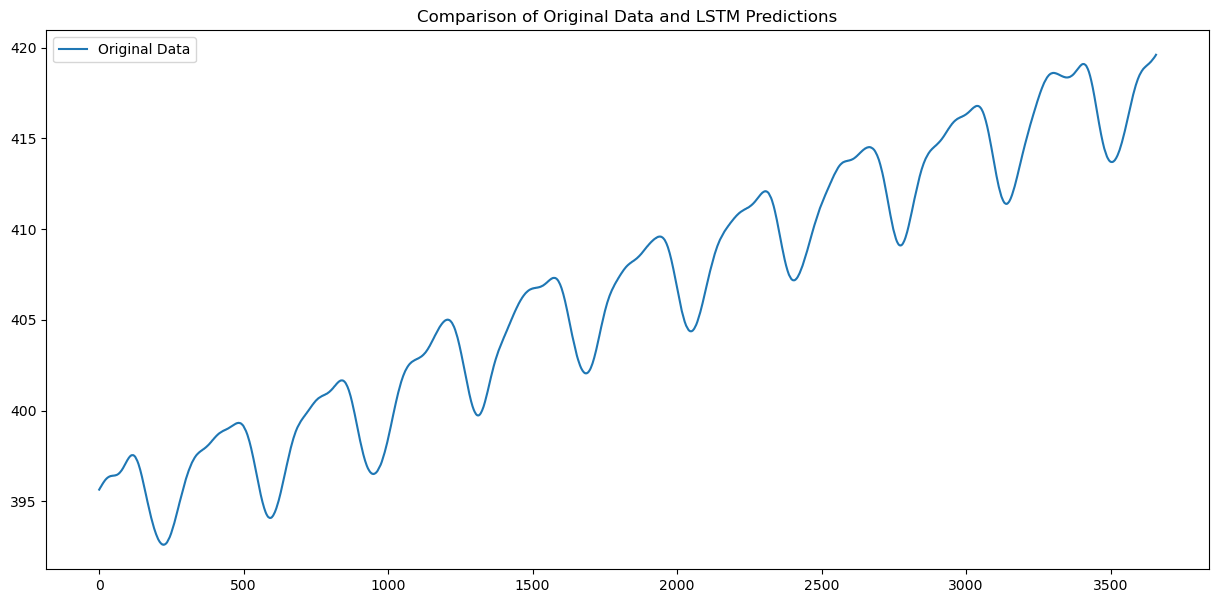

In [53]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 7))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.legend()
plt.title('Comparison of Original Data and LSTM Predictions')
plt.show()


# Hybrid Models Integration

##  Extract ARIMA Predictions and Calculate Residuals

In [54]:
predicted_values = model_fit.predict(start=data.index[0], end=data.index[-1])
residuals = data['cycle'] - predicted_values


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Train the ANN on Residuals

In [55]:
X = np.arange(len(residuals)).reshape(-1, 1)  
y = residuals.values

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ann_model = create_model(1, 20)  
ann_model.fit(X_train, y_train, epochs=10, batch_size=10)


Epoch 1/10
293/293 [==============================] - 1s 3ms/step - loss: 117139.5859
Epoch 2/10
293/293 [==============================] - 1s 2ms/step - loss: 37879.6641
Epoch 3/10
293/293 [==============================] - 1s 2ms/step - loss: 37735.0742
Epoch 4/10
293/293 [==============================] - 1s 3ms/step - loss: 37625.9922
Epoch 5/10
293/293 [==============================] - 1s 3ms/step - loss: 37508.6406
Epoch 6/10
293/293 [==============================] - 1s 3ms/step - loss: 37324.5742
Epoch 7/10
293/293 [==============================] - 1s 3ms/step - loss: 37160.5039
Epoch 8/10
293/293 [==============================] - 1s 3ms/step - loss: 37033.5000
Epoch 9/10
293/293 [==============================] - 1s 3ms/step - loss: 36859.6289
Epoch 10/10
293/293 [==============================] - 1s 3ms/step - loss: 36644.3047


# Predict Residuals and Adjust ARIMA Predictions

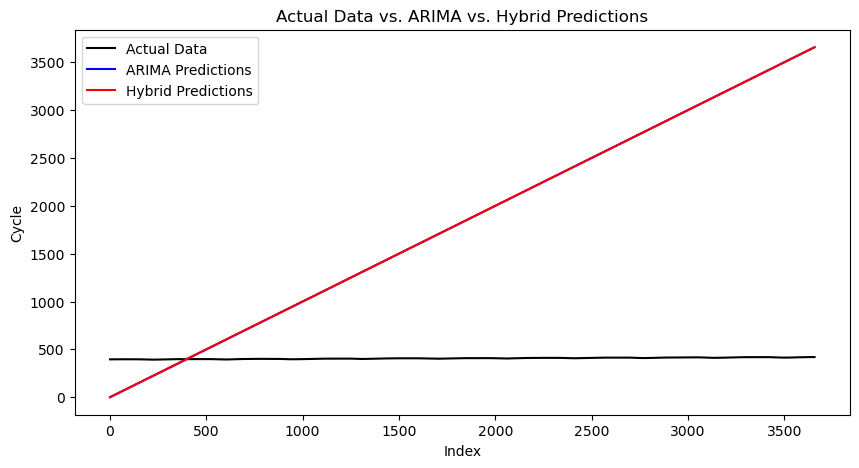

In [59]:


plt.figure(figsize=(10, 5))
plt.plot(data.index, data['cycle'], label='Actual Data', color='black')
plt.plot(data.index,  label='ARIMA Predictions', color='blue')
plt.plot(data.index,  label='Hybrid Predictions', color='red')
plt.legend()
plt.title('Actual Data vs. ARIMA vs. Hybrid Predictions')
plt.xlabel('Index')
plt.ylabel('Cycle')
plt.show()



# Plotting future predictions

In [60]:
if len(predicted_values) > len(data):
    future_indices = range(len(data), len(predicted_values))
    plt.figure(figsize=(10, 5))
    plt.plot(future_indices, predicted_values[len(data):], label='Future ARIMA Predictions', color='green')
    plt.plot(future_indices, adjusted_predictions[len(data):], label='Future Hybrid Predictions', color='purple')
    plt.legend()
    plt.title('Future Predictions')
    plt.xlabel('Index')
    plt.ylabel('Cycle')
    plt.show()


# Hybird Accuracy for ANN and ARIMA:


In [61]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Load the data
data = pd.read_csv('Daily_atmospheric_CO2_concentration.csv', parse_dates=True)

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Standardize the data
scaler = StandardScaler()
data[['cycle', 'trend']] = scaler.fit_transform(data[['cycle', 'trend']])

# Train the ARIMA model
p, d, q = 5, 0, 36
arima_model = ARIMA(data['cycle'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Predict with the ARIMA model
arima_predictions = arima_model_fit.predict(start=0, end=len(data)-1)

# Calculate residuals
residuals = data['cycle'] - arima_predictions

# Prepare data for ANN model
X = np.arange(len(residuals)).reshape(-1, 1)
y = residuals.values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the ANN model
def create_ann_model(input_dim, neurons):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

ann_model = create_ann_model(1, 20)
ann_model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)

# Make predictions with the ANN model
ann_predictions = ann_model.predict(X_test)

# Combine ARIMA and ANN predictions to form the hybrid model predictions
test_arima_predictions = arima_predictions[len(X_train):]
hybrid_predictions = test_arima_predictions + ann_predictions.flatten()

# Calculate the accuracy of the hybrid model
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_predictions))

print(f'Hybrid Model RMSE: {hybrid_rmse}')


C:\Users\fatii\AppData\Local\Temp\ipykernel_21364\694105359.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


23/23 [==============================] - 0s 2ms/step
Hybrid Model RMSE: 1.3670094582470287
